# **MILESTONE 1 i 2**


## **Cel biznesowy:** Segmentacja klientów banku na podstawie ich zachowań transakcyjnych i typów kont w celu personalizacji ofert marketingowych i zwiększenia retencji klientów

**Korzyści wynikające dla banku z racji takiego pogrupowania klientów:**

- Możliwość kierowania odpowiednich ofert do odpowiednich klientów (np. lokaty dla klientów z dużym saldem).

- Identyfikacja klientów wysokiego ryzyka lub niskiej aktywności.

- Możliwość tworzenia kampanii retencyjnych dla segmentów o niskim zaangażowaniu.

### Wczytanie ramki danych

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/banking_dataset.csv")

## **Eksploracja i wstępna analiza danych**

In [238]:
df.head()

,,Account ID;Customer Name;Account Type;Branch;Transaction Type;Transaction Amount;Account Balance;Currency
ACC00001;Amanda Pugh;Recurring Deposit;New York;Debit;2687,19;36676,19;GBP
ACC00002;Amanda Wilcox;Recurring Deposit;Houston;Debit;3886,77;28582,82;USD
ACC00003;Kimberly Valenzuela;Current;New York;Credit;2438,74;76599,56;GBP
ACC00004;Sonia Ballard;Recurring Deposit;Philadelphia;Credit;2758,53;62317,6;INR
ACC00005;Erika Russell;Current;Philadelphia;Debit;3287;85515,21;INR,NaN


Widzimy, że ramka danych po zapisaniu w pliku csv, nie ładuje się dobrze. Na szczęście jest na to rozwiązanie:

In [2]:
df = pd.read_csv("data/banking_dataset.csv", sep=";")


In [240]:
df.head()

,Account ID,Customer Name,Account Type,Branch,Transaction Type,Transaction Amount,Account Balance,Currency
0,ACC00001,Amanda Pugh,Recurring Deposit,New York,Debit,"2687,19","36676,19",GBP
1,ACC00002,Amanda Wilcox,Recurring Deposit,Houston,Debit,"3886,77","28582,82",USD
2,ACC00003,Kimberly Valenzuela,Current,New York,Credit,"2438,74","76599,56",GBP
3,ACC00004,Sonia Ballard,Recurring Deposit,Philadelphia,Credit,"2758,53","62317,6",INR
4,ACC00005,Erika Russell,Current,Philadelphia,Debit,3287,"85515,21",INR


In [241]:
df.tail()

,Account ID,Customer Name,Account Type,Branch,Transaction Type,Transaction Amount,Account Balance,Currency
9995,ACC09996,Richard Davis,Fixed Deposit,New York,Debit,"400,96","38035,17",USD
9996,ACC09997,Lauren Weber,Savings,Chicago,Debit,"3736,7","60682,41",EUR
9997,ACC09998,Nichole Stout,Fixed Deposit,Houston,Credit,"4002,91","36136,11",USD
9998,ACC09999,Kristen Wilkinson,Fixed Deposit,Philadelphia,Debit,"866,9","35644,82",GBP
9999,ACC10000,Brian Sandoval,Fixed Deposit,Philadelphia,Debit,"3932,81","32357,51",GBP


In [242]:
df.shape

(10000, 8)

In [243]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Account ID          10000 non-null  object
 1   Customer Name       10000 non-null  object
 2   Account Type        10000 non-null  object
 3   Branch              10000 non-null  object
 4   Transaction Type    10000 non-null  object
 5   Transaction Amount  10000 non-null  object
 6   Account Balance     10000 non-null  object
 7   Currency            10000 non-null  object
dtypes: object(8)
memory usage: 625.1+ KB


wszysktie kolumny są typu object - trzeba będzie to zmienić 

In [244]:
print(df.isnull().sum())

Account ID            0
Customer Name         0
Account Type          0
Branch                0
Transaction Type      0
Transaction Amount    0
Account Balance       0
Currency              0
dtype: int64


Brak pustych wartości

In [245]:
df.describe()

,Account ID,Customer Name,Account Type,Branch,Transaction Type,Transaction Amount,Account Balance,Currency
count,10000,10000,10000,10000,10000,10000,10000,10000
unique,10000,9323,4,8,2,9896,9995,5
top,ACC00001,William Williams,Savings,Philadelphia,Credit,"3398,97","21317,69",JPY
freq,1,7,2580,1288,5114,3,2,2041


## Po wstępnej analizie kolumn, usunięte zostaną kolumny 'Account ID' oraz 'Customer Name', są to informacje, które nie wnoszą żadnej informacji

komentarz: czy na pewno accountID? Czy nie warto zostawić dla samego celu identyfikacyjnego konta?

In [3]:
df = df.drop(['Account ID', 'Customer Name'], axis = 1)

In [247]:
df.head()

,Account Type,Branch,Transaction Type,Transaction Amount,Account Balance,Currency
0,Recurring Deposit,New York,Debit,"2687,19","36676,19",GBP
1,Recurring Deposit,Houston,Debit,"3886,77","28582,82",USD
2,Current,New York,Credit,"2438,74","76599,56",GBP
3,Recurring Deposit,Philadelphia,Credit,"2758,53","62317,6",INR
4,Current,Philadelphia,Debit,3287,"85515,21",INR


In [4]:
df.drop_duplicates(inplace=True) #to może nie być poprawne

Możemy teraz przejść do dalszej eksploracji danych, najpierw zmieńmy typy danych w kolumnach, aby móc operować na zmiennych liczbowych

In [5]:
#df['Transaction Amount'] = pd.to_numeric(df['Transaction Amount'], errors='coerce')
#df['Account Balance'] = pd.to_numeric(df['Account Balance'], errors='coerce')

df['Transaction Amount'] = df['Transaction Amount'].str.replace(',', '.').astype(float)
df['Account Balance'] = df['Account Balance'].str.replace(',', '.').astype(float)

^ tutaj był błąd, zakomentowany kod psuł tabelę

Sprawdźmy unikalne wartości i ich ilość dla poszczególnych kolumn

In [250]:
print(df.dtypes)

Account Type           object
Branch                 object
Transaction Type       object
Transaction Amount    float64
Account Balance       float64
Currency               object
dtype: object


In [251]:
for col in ['Account Type', 'Branch', 'Transaction Type', 'Currency']:
    print(f"\nUnikalne wartości w kolumnie {col}:")
    print(df[col].value_counts())


Unikalne wartości w kolumnie Account Type:
Account Type
Savings              2580
Current              2529
Fixed Deposit        2489
Recurring Deposit    2402
Name: count, dtype: int64

Unikalne wartości w kolumnie Branch:
Branch
Philadelphia    1288
Phoenix         1274
Los Angeles     1268
Houston         1259
New York        1256
Chicago         1239
San Antonio     1233
San Diego       1183
Name: count, dtype: int64

Unikalne wartości w kolumnie Transaction Type:
Transaction Type
Credit    5114
Debit     4886
Name: count, dtype: int64

Unikalne wartości w kolumnie Currency:
Currency
JPY    2041
EUR    2039
USD    2035
GBP    1958
INR    1927
Name: count, dtype: int64


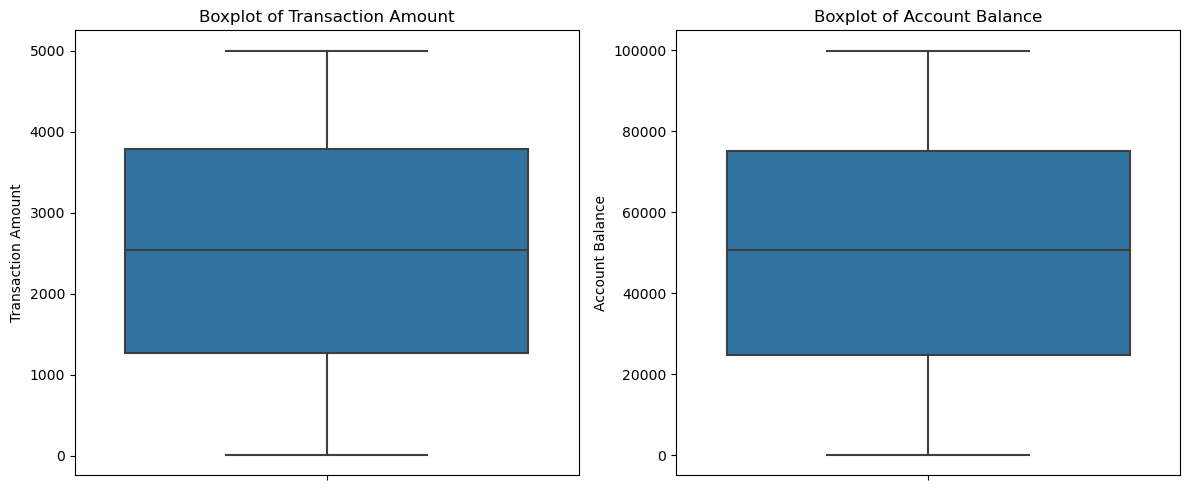

In [252]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['Transaction Amount'])
plt.title('Boxplot of Transaction Amount')
plt.subplot(1, 2, 2)
sns.boxplot(y=df['Account Balance'])
plt.title('Boxplot of Account Balance')
plt.tight_layout()
plt.show()

**Nie ma widocznych żadnych outlierów.**

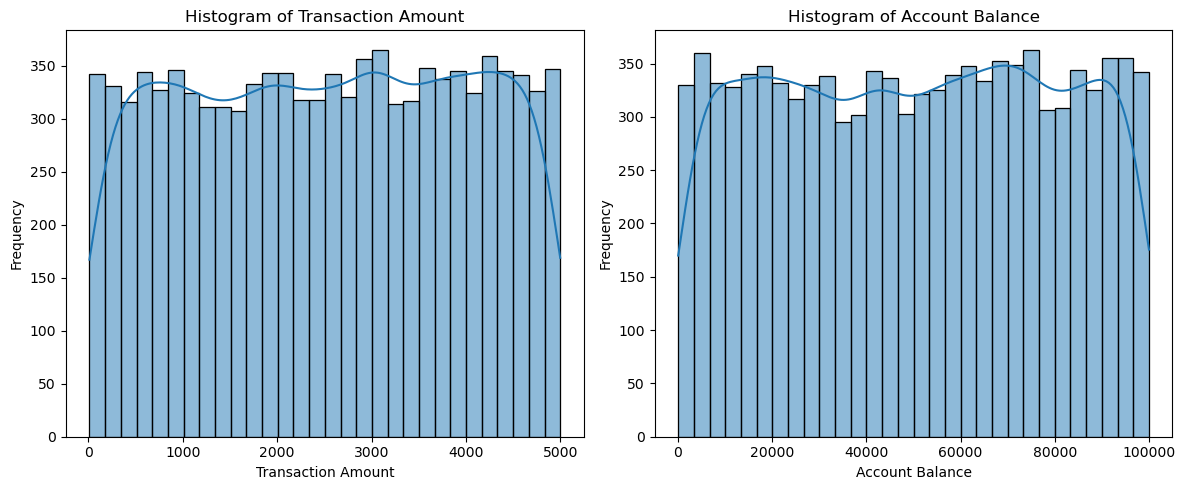

In [253]:
plt.figure(figsize=(12, 5))

# Transaction amount
plt.subplot(1, 2, 1)
sns.histplot(df['Transaction Amount'], bins=30, kde=True)
plt.title('Histogram of Transaction Amount')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')

# Acc balance
plt.subplot(1, 2, 2)
sns.histplot(df['Account Balance'], bins=30, kde=True)
plt.title('Histogram of Account Balance')
plt.xlabel('Account Balance')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

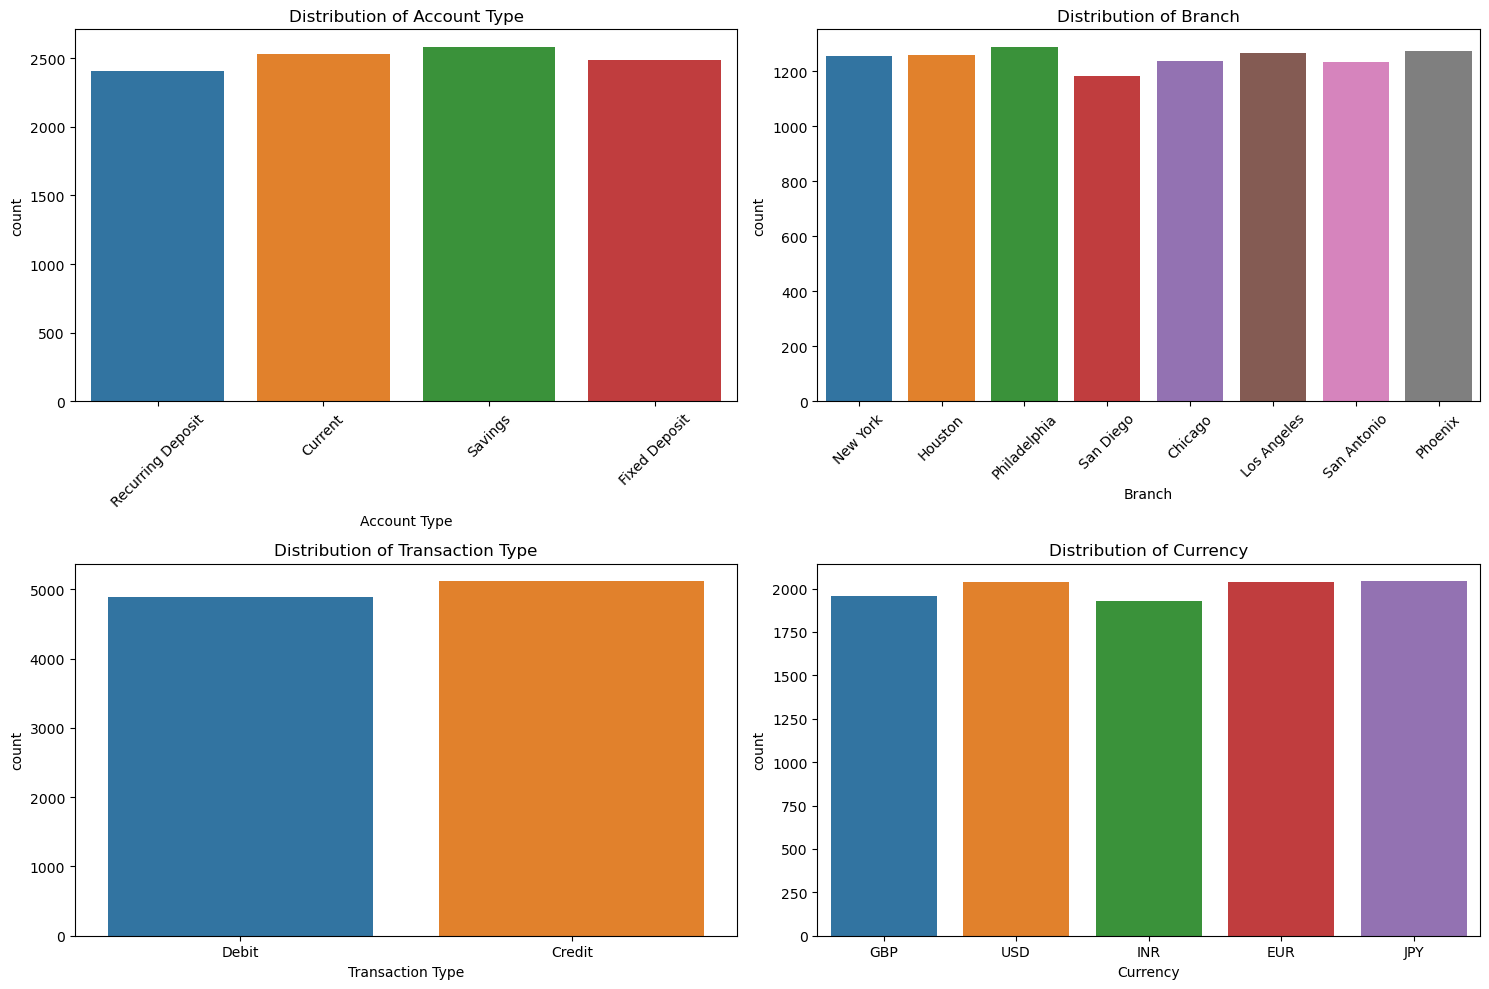

In [254]:
# Count plots for categorical variables
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.countplot(x='Account Type', data=df)
plt.title('Distribution of Account Type')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
sns.countplot(x='Branch', data=df)
plt.title('Distribution of Branch')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
sns.countplot(x='Transaction Type', data=df)
plt.title('Distribution of Transaction Type')

plt.subplot(2, 2, 4)
sns.countplot(x='Currency', data=df)
plt.title('Distribution of Currency')
plt.tight_layout()
plt.show()


Dla każdej zmiennej kategorycznej zliczenia możliwych wartości są rozłożone mniej więcej po równo.

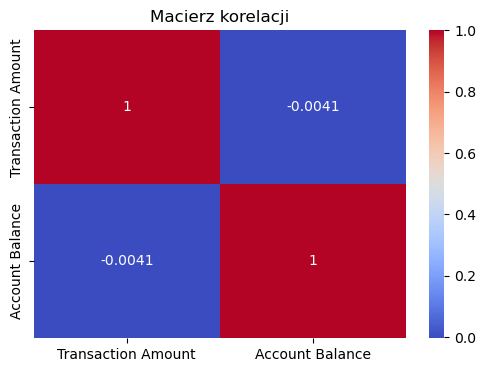

In [255]:
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Macierz korelacji")
plt.show()

Macierz korelacji

In [256]:
print(df.groupby('Account Type')['Transaction Amount'].mean())

print(df.groupby('Currency')['Account Balance'].mean())


Account Type
Current              2502.820059
Fixed Deposit        2546.617151
Recurring Deposit    2512.312627
Savings              2536.010089
Name: Transaction Amount, dtype: float64
Currency
EUR    50502.715473
GBP    49906.100516
INR    51049.621271
JPY    49827.480314
USD    50091.525027
Name: Account Balance, dtype: float64


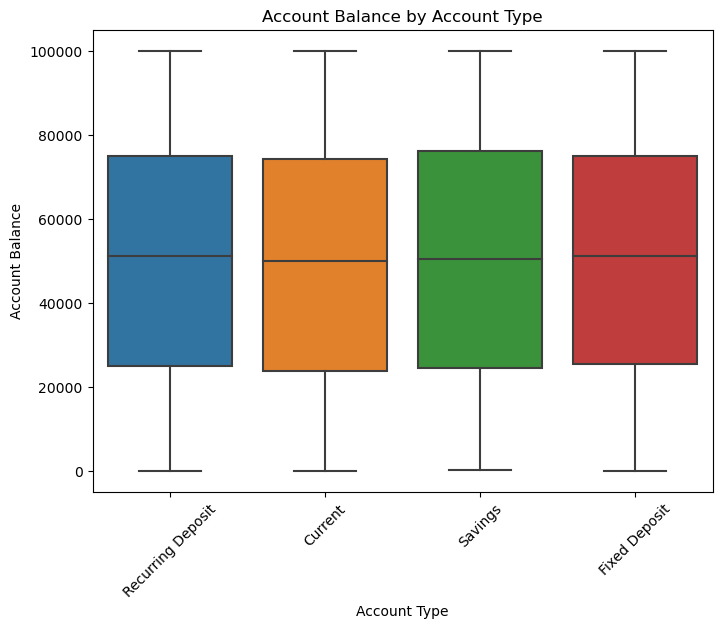

In [257]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Account Type', y='Account Balance', data=df)
plt.title('Account Balance by Account Type')
plt.xticks(rotation=45)
plt.show()

Brak outlierów. Rozkład stanu konta w zależności od typu konta

In [258]:
# Cross-tabulation of Account Type and Transaction Type
print(pd.crosstab(df['Account Type'], df['Transaction Type']))

Transaction Type   Credit  Debit
Account Type                    
Current              1323   1206
Fixed Deposit        1266   1223
Recurring Deposit    1206   1196
Savings              1319   1261


Po równo.

# **Inżynieria cech**

W tej części projektu skupimy się na utworzeniu nowych zmiennych tak, aby mogły one pogrupować danych klientów w odpowiednie grupy.

## **Zamiana na jedną walutę i ponowne przeprowadzenie analizy**

In [6]:
exchange_rates = {'USD': 1.0, 'EUR': 1.08, 'GBP': 1.27, 'INR': 0.012, 'JPY': 0.0066}

# Zamiana na USD
df['Transaction Amount USD'] = df.apply(lambda x: float(x['Transaction Amount']) * exchange_rates.get(x['Currency'], 1.0), axis=1)
df['Account Balance USD'] = df.apply(lambda x: float(x['Account Balance']) * exchange_rates.get(x['Currency'], 1.0), axis=1)

# sprawdzamy czy dizała
print(df[['Transaction Amount USD', 'Account Balance USD']].describe())


       Transaction Amount USD  Account Balance USD
count            10000.000000         10000.000000
mean              1704.556596         33910.047464
std               1870.159242         37213.913721
min                  0.082434             0.897336
25%                 26.736683           535.726967
50%                950.329000         18802.265000
75%               3277.854375         65177.548200
max               6347.510800        126968.999300


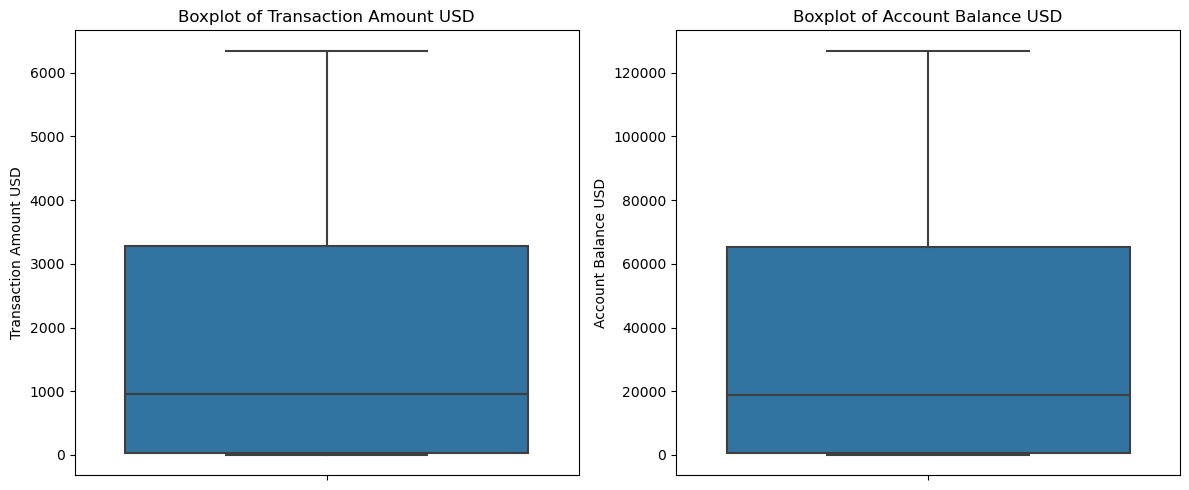

In [260]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['Transaction Amount USD'])
plt.title('Boxplot of Transaction Amount USD')
plt.subplot(1, 2, 2)
sns.boxplot(y=df['Account Balance USD'])
plt.title('Boxplot of Account Balance USD')
plt.tight_layout()
plt.show()

Brak outlierów w USD

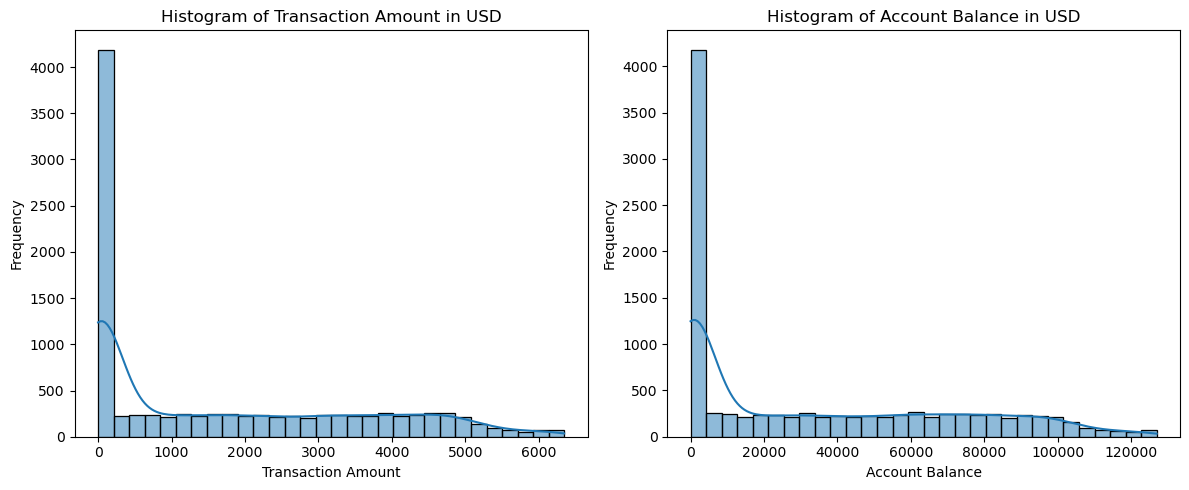

In [261]:
plt.figure(figsize=(12, 5))

# Histogram dla Transaction Amount
plt.subplot(1, 2, 1)
sns.histplot(df['Transaction Amount USD'], bins=30, kde=True)
plt.title('Histogram of Transaction Amount in USD')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')

# Histogram dla Account Balance
plt.subplot(1, 2, 2)
sns.histplot(df['Account Balance USD'], bins=30, kde=True)
plt.title('Histogram of Account Balance in USD')
plt.xlabel('Account Balance')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Bardzo mocna skośność, sprwadźmy jak prezentują się wykresy z wartością zlogarytmowaną.

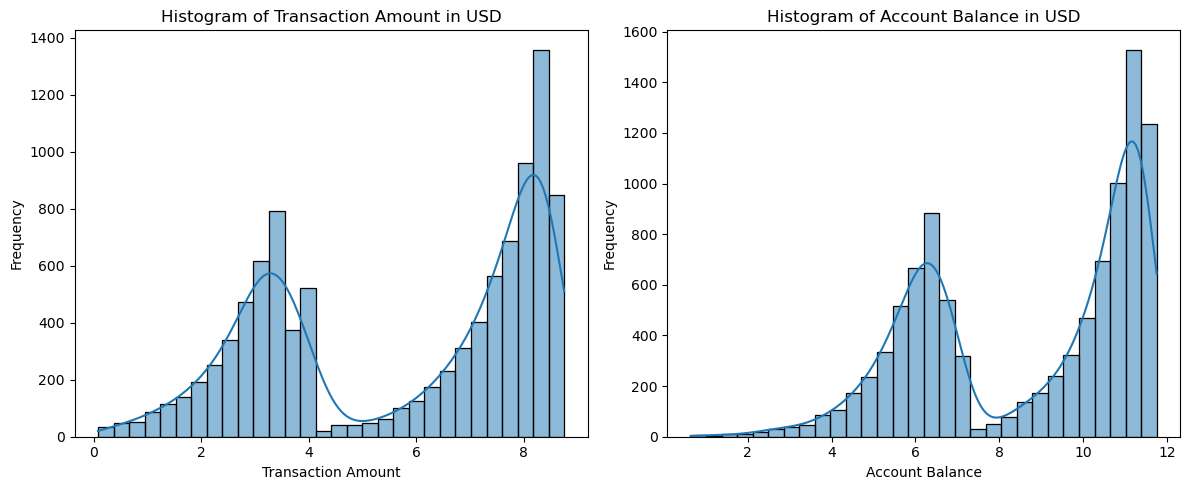

In [262]:
plt.figure(figsize=(12, 5))

# Histogram dla Transaction Amount
plt.subplot(1, 2, 1)
sns.histplot(x=np.log1p(df['Transaction Amount USD']), bins=30, kde=True) 
plt.title('Histogram of Transaction Amount in USD')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')

# Histogram dla Account Balance
plt.subplot(1, 2, 2)
sns.histplot(x=np.log1p(df['Account Balance USD']), bins=30, kde=True) 
plt.title('Histogram of Account Balance in USD')
plt.xlabel('Account Balance')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Utworzymy dodatkowe kolumny, wygląda dobrze

In [7]:
df['Transaction Amount USD log'] = np.log1p(df['Transaction Amount USD'])
df['Account Balance USD log'] = np.log1p(df['Account Balance USD'])

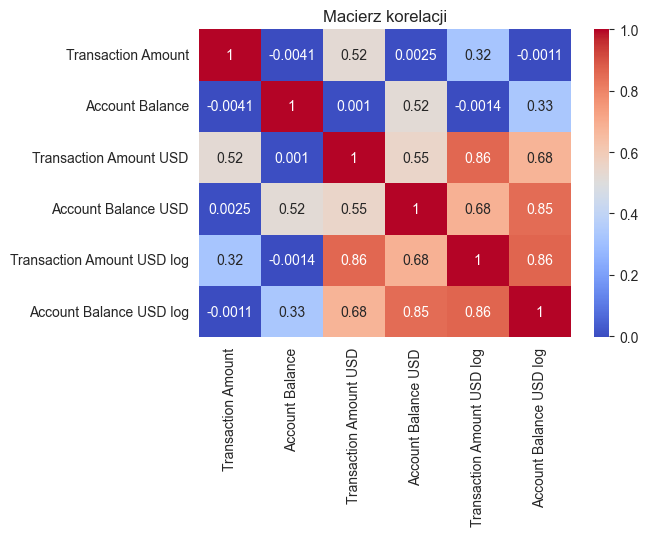

In [8]:
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Macierz korelacji")
plt.show()

Zmienienie waluty na jedną sprawia, że kolumny odpowiadające za stan konta oraz wartość transakcji są mocniej skorelowane, a po zlogarytmowaniu ich ta korelacja jest już na prawdę bardzo wysoka. Prawdopodobnie lepiej jest zostać przy oryginalnej wartości Transaction Amount oraz Account Balance, ale brać pod uwagę kolumnę Currency, która będzie nam mówić o walucie.

In [9]:
df = df.drop(['Transaction Amount USD', 'Account Balance USD', 'Transaction Amount USD log', 'Account Balance USD log'], axis = 1)

In [10]:
print(df.columns)

Index(['Account Type', 'Branch', 'Transaction Type', 'Transaction Amount',
       'Account Balance', 'Currency'],
      dtype='object')


In [11]:
df = pd.get_dummies(df, columns=['Currency'], prefix='Currency')

In [14]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler

features = ['Transaction Amount', 'Account Balance'] + list(df.filter(like='Currency_').columns) 

df1 = df[features]

X = df1.values

# t-SNE dla nieprzekształconych danych
tsne_raw = TSNE(n_components=2, random_state=42)
X_tsne_raw = tsne_raw.fit_transform(X)

# 2. t-SNE dla danych po normalizacji
X_minmax = MinMaxScaler().fit_transform(X)
X_tsne_minmax = TSNE(n_components=2, random_state=42).fit_transform(X_minmax)

# 3. t-SNE dla danych po standaryzacji
X_standard = StandardScaler().fit_transform(X)
X_tsne_standard = TSNE(n_components=2, random_state=42).fit_transform(X_standard)

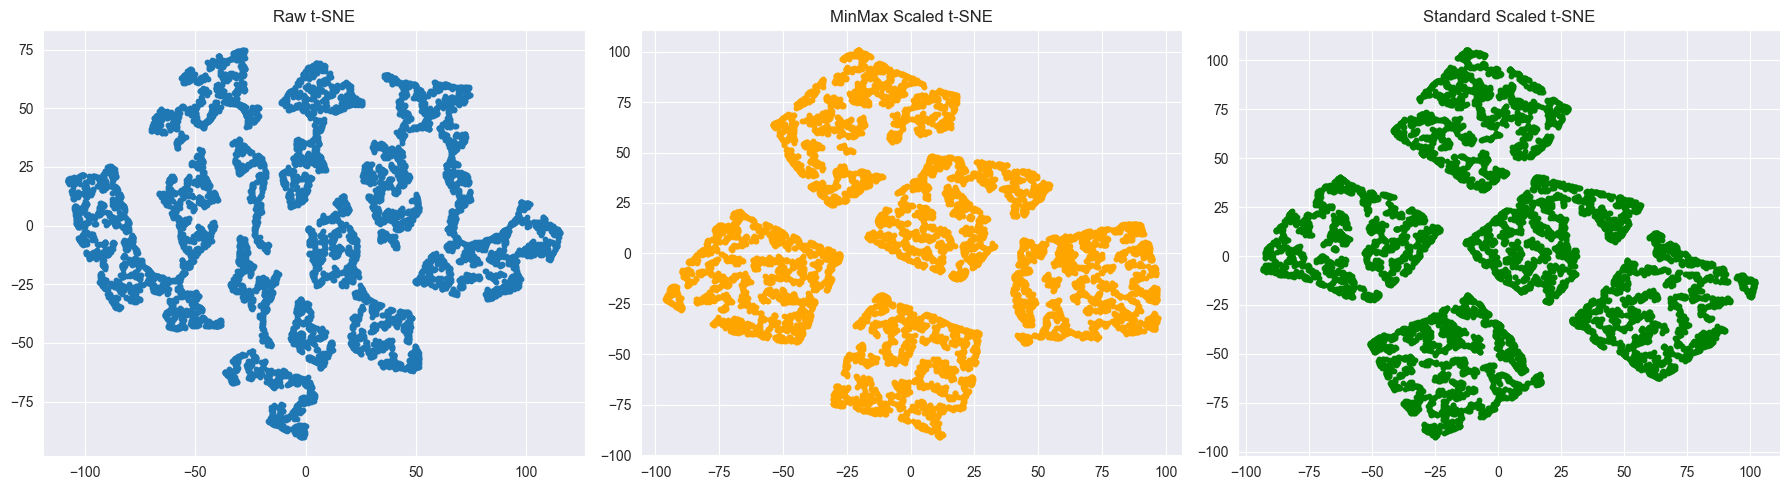

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(X_tsne_raw[:, 0], X_tsne_raw[:, 1], s=10)
axes[0].set_title('Raw t-SNE')

axes[1].scatter(X_tsne_minmax[:, 0], X_tsne_minmax[:, 1], s=10, c='orange')
axes[1].set_title('MinMax Scaled t-SNE')

axes[2].scatter(X_tsne_standard[:, 0], X_tsne_standard[:, 1], s=10, c='green')
axes[2].set_title('Standard Scaled t-SNE')

plt.tight_layout()
plt.show()

In [16]:
df['Activity_Ratio'] = df['Account Balance'] / (df['Transaction Amount'] + 1)
df['Log_Activity_Ratio'] = np.log1p(df['Activity_Ratio'].clip(lower=1e-6))

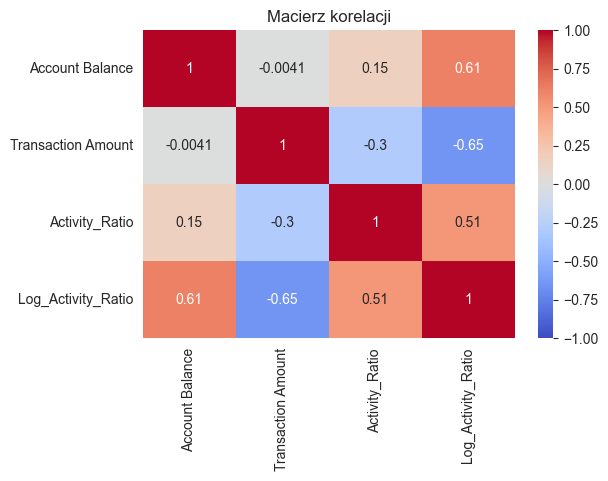

In [17]:
plt.figure(figsize=(6, 4))
sns.heatmap(df[['Account Balance', 'Transaction Amount', 'Activity_Ratio', 'Log_Activity_Ratio']].corr(), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Macierz korelacji")
plt.show()

In [18]:
df = df.drop(['Log_Activity_Ratio'], axis=1)

In [33]:
features = ['Transaction Amount', 'Account Balance', 'Activity_Ratio'] + list(df.filter(like='Currency_').columns) 

df1 = df[features]

X = df1.values

# t-SNE dla nieprzekształconych danych
tsne_raw = TSNE(n_components=2, random_state=42)
X_tsne_raw = tsne_raw.fit_transform(X)

# 2. t-SNE dla danych po normalizacji
X_minmax = MinMaxScaler().fit_transform(X)
X_tsne_minmax = TSNE(n_components=2, random_state=42).fit_transform(X_minmax)

# 3. t-SNE dla danych po standaryzacji
X_standard = StandardScaler().fit_transform(X)
X_tsne_standard = TSNE(n_components=2, random_state=42).fit_transform(X_standard)

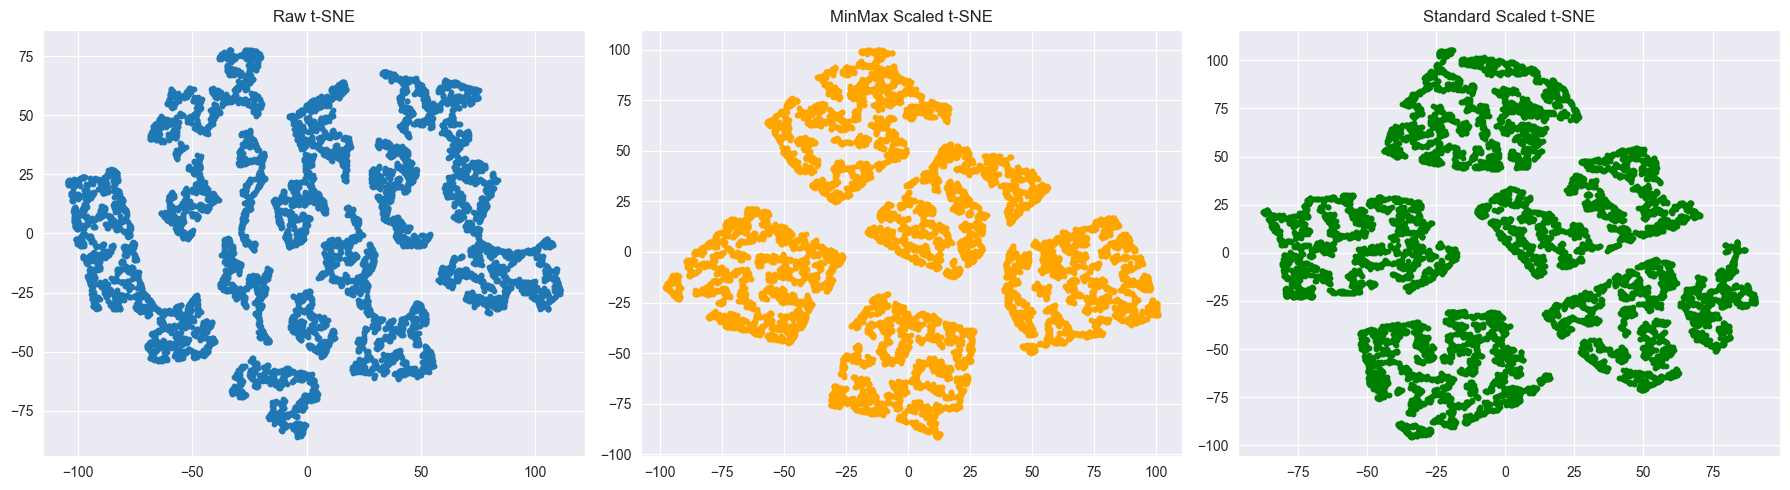

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(X_tsne_raw[:, 0], X_tsne_raw[:, 1], s=10)
axes[0].set_title('Raw t-SNE')

axes[1].scatter(X_tsne_minmax[:, 0], X_tsne_minmax[:, 1], s=10, c='orange')
axes[1].set_title('MinMax Scaled t-SNE')

axes[2].scatter(X_tsne_standard[:, 0], X_tsne_standard[:, 1], s=10, c='green')
axes[2].set_title('Standard Scaled t-SNE')

plt.tight_layout()
plt.show()

In [34]:
from sklearn.cluster import DBSCAN

dbsc_Xraw = DBSCAN(n_jobs=-1).fit_predict(X_tsne_raw)
dbsc_Xminmax = DBSCAN(n_jobs=-1).fit_predict(X_minmax)
dbsc_Xstandard = DBSCAN(n_jobs=-1).fit_predict(X_standard)

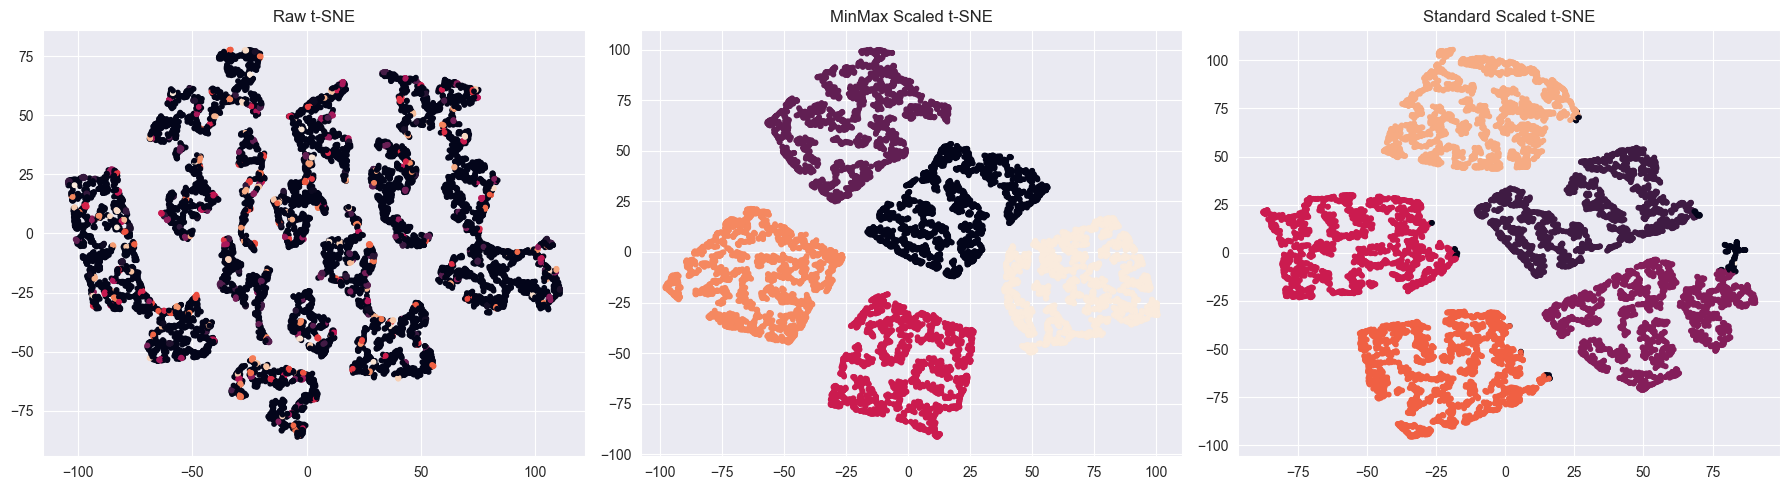

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(X_tsne_raw[:, 0], X_tsne_raw[:, 1], s=10, c=dbsc_Xraw)
axes[0].set_title('Raw t-SNE')

axes[1].scatter(X_tsne_minmax[:, 0], X_tsne_minmax[:, 1], s=10, c=dbsc_Xminmax)
axes[1].set_title('MinMax Scaled t-SNE')

axes[2].scatter(X_tsne_standard[:, 0], X_tsne_standard[:, 1], s=10, c=dbsc_Xstandard)
axes[2].set_title('Standard Scaled t-SNE')

plt.tight_layout()
plt.show()

np.int64(1927)

To co wyżej tylko bez kolumn Currency

In [29]:
features = ['Transaction Amount', 'Account Balance', 'Activity_Ratio'] #+ list(df.filter(like='Currency_').columns)

df1 = df[features]

X = df1.values

# t-SNE dla nieprzekształconych danych
tsne_raw = TSNE(n_components=2, random_state=42)
X_tsne_raw = tsne_raw.fit_transform(X)

# 2. t-SNE dla danych po normalizacji
X_minmax = MinMaxScaler().fit_transform(X)
X_tsne_minmax = TSNE(n_components=2, random_state=42).fit_transform(X_minmax)

# 3. t-SNE dla danych po standaryzacji
X_standard = StandardScaler().fit_transform(X)
X_tsne_standard = TSNE(n_components=2, random_state=42).fit_transform(X_standard)

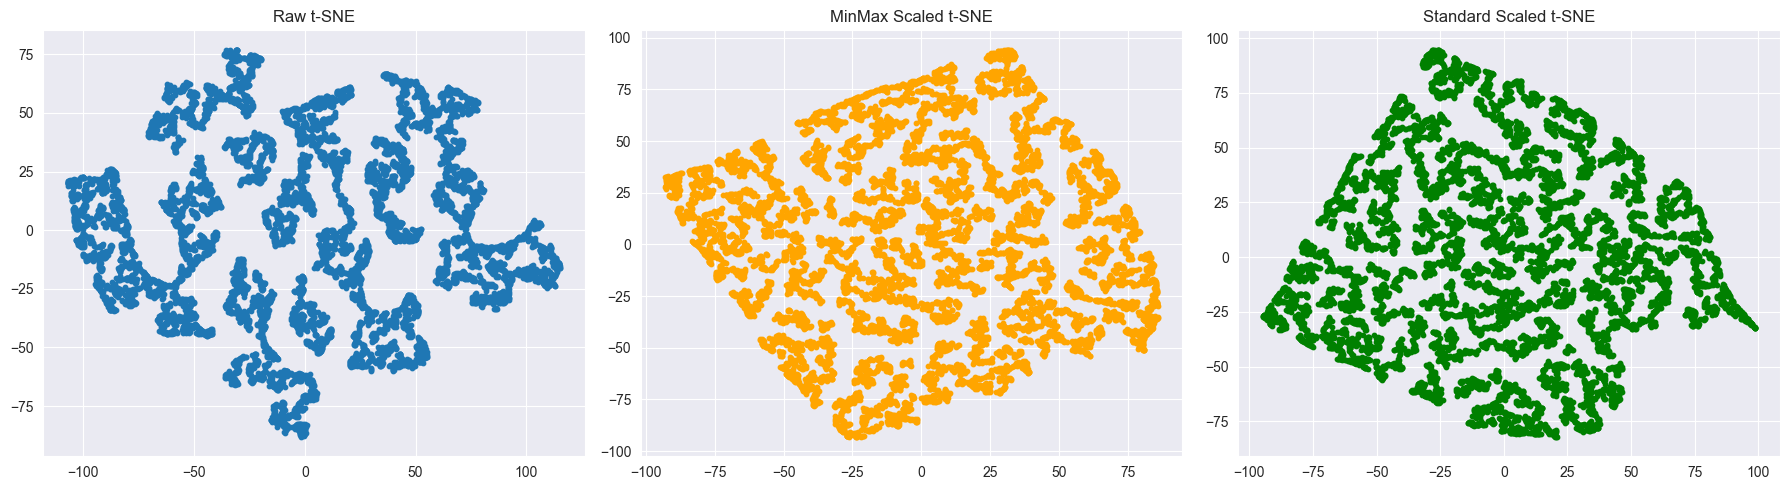

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(X_tsne_raw[:, 0], X_tsne_raw[:, 1], s=10)
axes[0].set_title('Raw t-SNE')

axes[1].scatter(X_tsne_minmax[:, 0], X_tsne_minmax[:, 1], s=10, c='orange')
axes[1].set_title('MinMax Scaled t-SNE')

axes[2].scatter(X_tsne_standard[:, 0], X_tsne_standard[:, 1], s=10, c='green')
axes[2].set_title('Standard Scaled t-SNE')

plt.tight_layout()
plt.show()

In [31]:
from sklearn.cluster import DBSCAN

dbsc_Xraw = DBSCAN(n_jobs=-1).fit_predict(X_tsne_raw)
dbsc_Xminmax = DBSCAN(n_jobs=-1).fit_predict(X_minmax)
dbsc_Xstandard = DBSCAN(n_jobs=-1).fit_predict(X_standard)

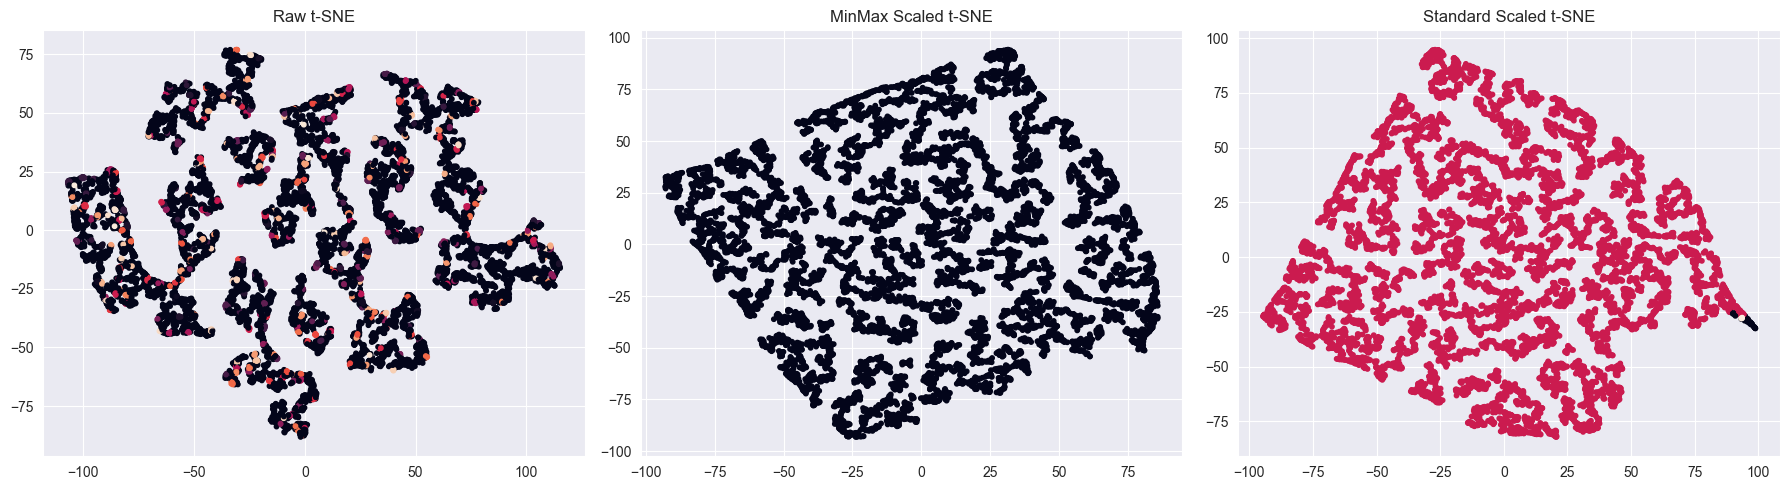

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(X_tsne_raw[:, 0], X_tsne_raw[:, 1], s=10, c=dbsc_Xraw)
axes[0].set_title('Raw t-SNE')

axes[1].scatter(X_tsne_minmax[:, 0], X_tsne_minmax[:, 1], s=10, c=dbsc_Xminmax)
axes[1].set_title('MinMax Scaled t-SNE')

axes[2].scatter(X_tsne_standard[:, 0], X_tsne_standard[:, 1], s=10, c=dbsc_Xstandard)
axes[2].set_title('Standard Scaled t-SNE')

plt.tight_layout()
plt.show()

Czyli ewentualne klastry będą zależały tylko od waluty. To chyba nie jest nasz cel

In [43]:
features = list(df.filter(like='Currency_').columns)

df1 = df[features]

X = df1.values

# t-SNE dla nieprzekształconych danych
tsne_raw = TSNE(n_components=2, random_state=42)
X_tsne_raw = tsne_raw.fit_transform(X)

# 2. t-SNE dla danych po normalizacji
X_minmax = MinMaxScaler().fit_transform(X)
X_tsne_minmax = TSNE(n_components=2, random_state=42).fit_transform(X_minmax)

# 3. t-SNE dla danych po standaryzacji
X_standard = StandardScaler().fit_transform(X)
X_tsne_standard = TSNE(n_components=2, random_state=42).fit_transform(X_standard)

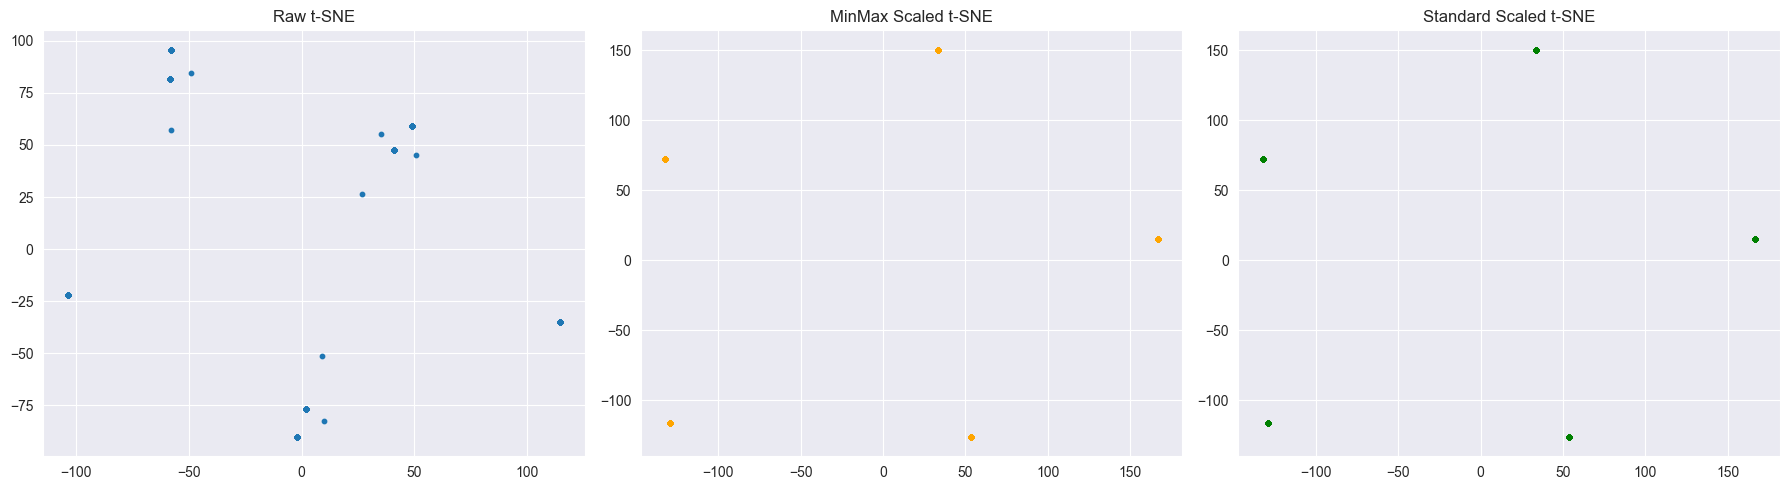

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(X_tsne_raw[:, 0], X_tsne_raw[:, 1], s=10)
axes[0].set_title('Raw t-SNE')

axes[1].scatter(X_tsne_minmax[:, 0], X_tsne_minmax[:, 1], s=10, c='orange')
axes[1].set_title('MinMax Scaled t-SNE')

axes[2].scatter(X_tsne_standard[:, 0], X_tsne_standard[:, 1], s=10, c='green')
axes[2].set_title('Standard Scaled t-SNE')

plt.tight_layout()
plt.show()

To samo ale bez features numerycznych

In [275]:
features = ['Activity_Ratio'] + list(df.filter(like='Currency_').columns) 

df1 = df[features]

X = df1.values

# t-SNE dla nieprzekształconych danych
tsne_raw = TSNE(n_components=2, random_state=42)
X_tsne_raw = tsne_raw.fit_transform(X)

# 2. t-SNE dla danych po normalizacji
X_minmax = MinMaxScaler().fit_transform(X)
X_tsne_minmax = TSNE(n_components=2, random_state=42).fit_transform(X_minmax)

# 3. t-SNE dla danych po standaryzacji
X_standard = StandardScaler().fit_transform(X)
X_tsne_standard = TSNE(n_components=2, random_state=42).fit_transform(X_standard)

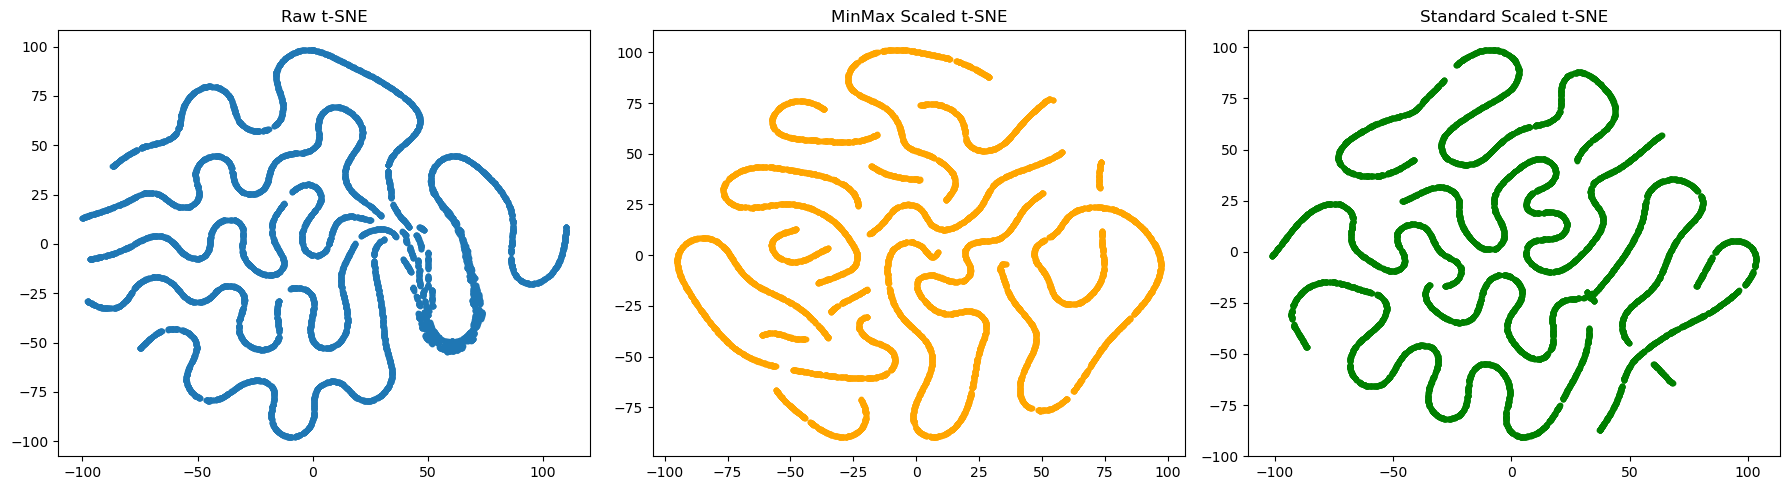

In [276]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(X_tsne_raw[:, 0], X_tsne_raw[:, 1], s=10)
axes[0].set_title('Raw t-SNE')

axes[1].scatter(X_tsne_minmax[:, 0], X_tsne_minmax[:, 1], s=10, c='orange')
axes[1].set_title('MinMax Scaled t-SNE')

axes[2].scatter(X_tsne_standard[:, 0], X_tsne_standard[:, 1], s=10, c='green')
axes[2].set_title('Standard Scaled t-SNE')

plt.tight_layout()
plt.show()

Znowu to co wyżej ale bez currency

In [277]:
df['Account_Type_Original'] = df['Account Type'].copy()
df = pd.get_dummies(df, columns=['Account Type'], prefix='Account_Type')
df['Account_Balance_Relative_to_Mean_AccType'] = df['Account Balance'] / df.groupby('Account_Type_Original')['Account Balance'].transform('mean')
df = df.drop('Account_Type_Original', axis=1)

Zmienna mówiąca o tym, czy ktoś o danym typie konta ma większy czy mniejszy stan konta

In [278]:
df['Transaction_Type_Original'] = df['Transaction Type'].copy()
df = pd.get_dummies(df, columns=['Transaction Type'], prefix='Transaction_Type')
df['Transaction_Amount_Relative_to_Mean_TransType'] = df['Transaction Amount'] / df.groupby('Transaction_Type_Original')['Transaction Amount'].transform('mean')
df = df.drop('Transaction_Type_Original', axis=1)

Zmienna mówiąca o tym czy dana transakcja była większa czy mniejsza od średniej transakcji w zależności od typu transakcji

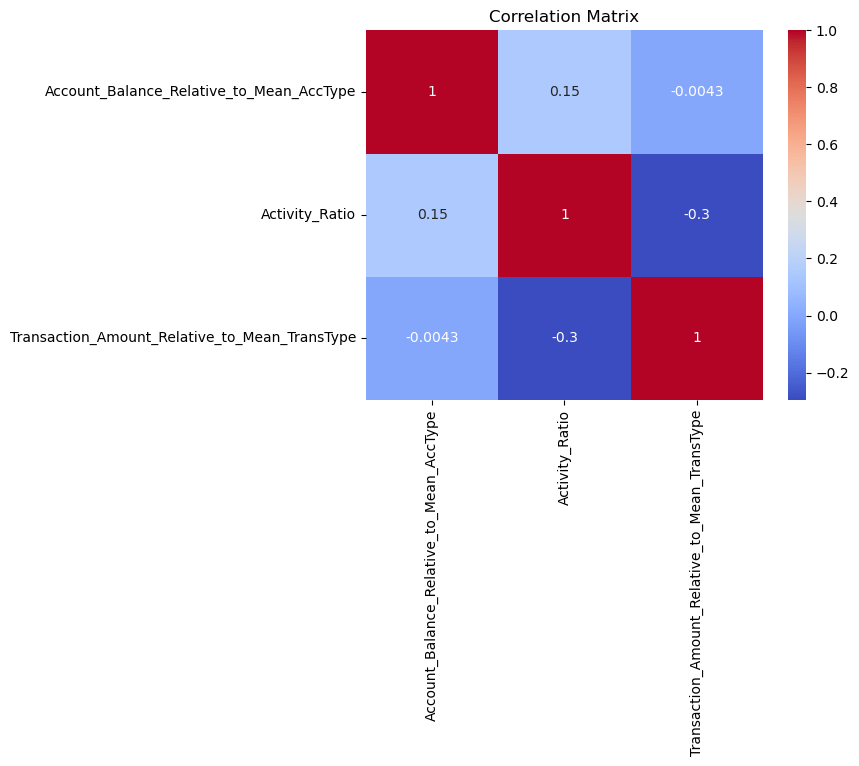

In [279]:
correlation_matrix = df[['Account_Balance_Relative_to_Mean_AccType', 'Activity_Ratio', 'Transaction_Amount_Relative_to_Mean_TransType']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [319]:
features = ['Activity_Ratio', 'Account_Balance_Relative_to_Mean_AccType', 'Transaction_Amount_Relative_to_Mean_TransType'] + list(df.filter(like='Currency_').columns) 

df1 = df[features]

X = df1.values

# t-SNE dla nieprzekształconych danych
tsne_raw = TSNE(n_components=2, random_state=42)
X_tsne_raw = tsne_raw.fit_transform(X)

# 2. t-SNE dla danych po normalizacji
X_minmax = MinMaxScaler().fit_transform(X)
X_tsne_minmax = TSNE(n_components=2, random_state=42).fit_transform(X_minmax)

# 3. t-SNE dla danych po standaryzacji
X_standard = StandardScaler().fit_transform(X)
X_tsne_standard = TSNE(n_components=2, random_state=42).fit_transform(X_standard)

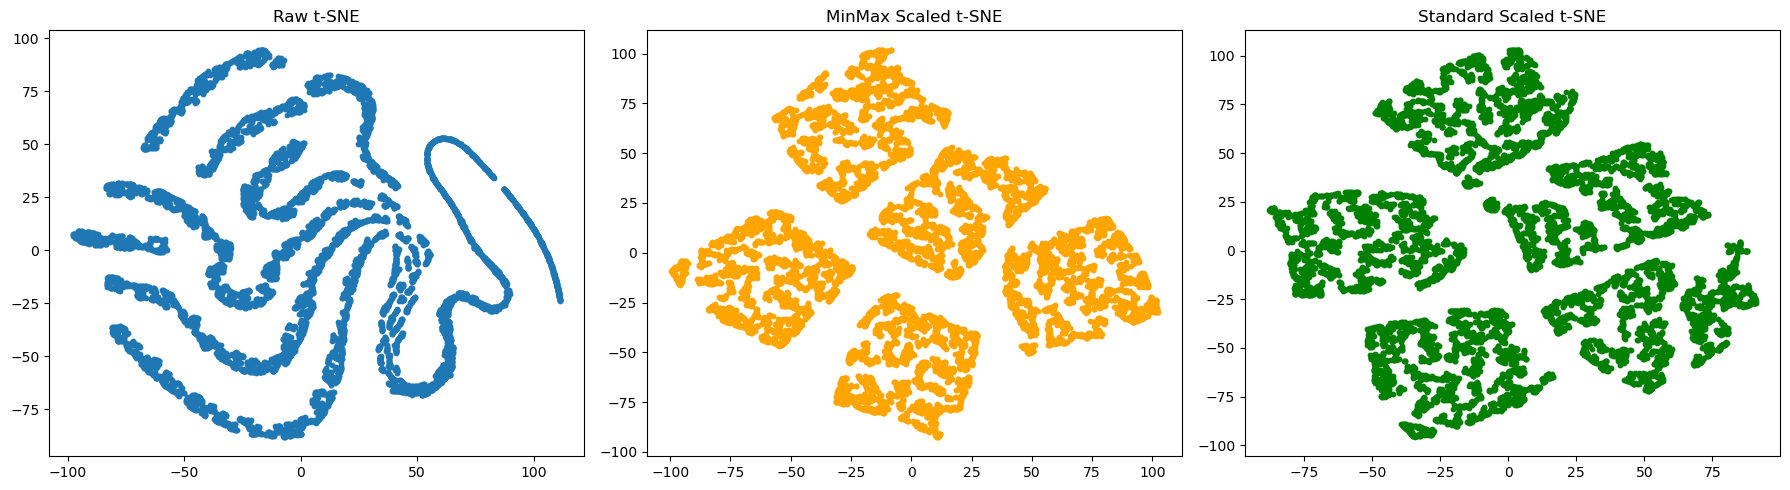

In [281]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(X_tsne_raw[:, 0], X_tsne_raw[:, 1], s=10)
axes[0].set_title('Raw t-SNE')

axes[1].scatter(X_tsne_minmax[:, 0], X_tsne_minmax[:, 1], s=10, c='orange')
axes[1].set_title('MinMax Scaled t-SNE')

axes[2].scatter(X_tsne_standard[:, 0], X_tsne_standard[:, 1], s=10, c='green')
axes[2].set_title('Standard Scaled t-SNE')

plt.tight_layout()
plt.show()

c:\Users\48530\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


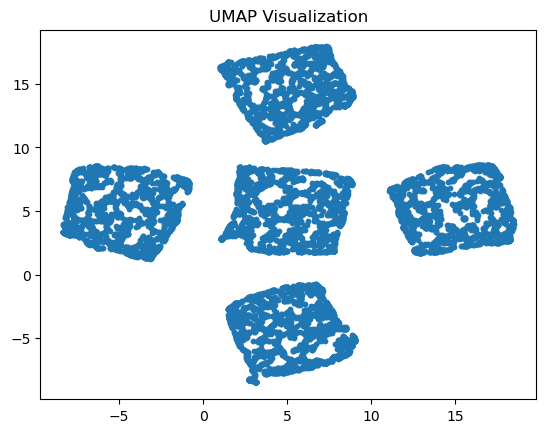

In [313]:
import umap

umap_model = umap.UMAP(n_components=4, random_state=42, n_neighbors=15, min_dist=0.1)
X_umap = umap_model.fit_transform(X_minmax)

plt.scatter(X_umap[:, 0], X_umap[:, 1], s=10)
plt.title('UMAP Visualization')
plt.show()

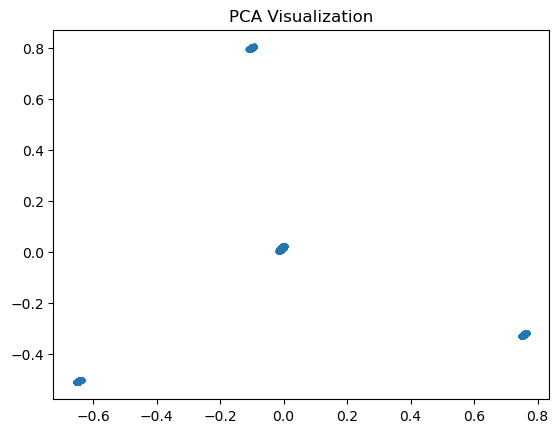

Wyjaśniona wariancja: [0.21085702 0.21048692]


In [320]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_minmax)
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10)
plt.title('PCA Visualization')
plt.show()
print("Wyjaśniona wariancja:", pca.explained_variance_ratio_)

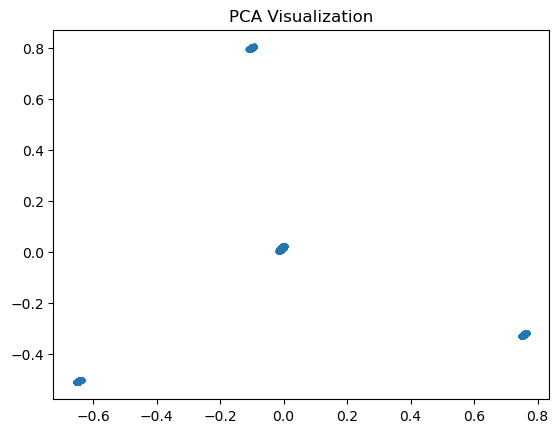

Wyjaśniona wariancja: [0.21085702 0.21048692 0.20497842 0.20040394]


In [321]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_minmax)
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10)
plt.title('PCA Visualization')
plt.show()
print("Wyjaśniona wariancja:", pca.explained_variance_ratio_)

In [323]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_minmax)
kmeans_pca = KMeans(n_clusters=4, random_state=42)
clusters_pca = kmeans_pca.fit_predict(X_pca)
print("Silhouette Score (PCA):", silhouette_score(X_pca, clusters_pca))

# UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_minmax)
kmeans_umap = KMeans(n_clusters=5, random_state=42)
clusters_umap = kmeans_umap.fit_predict(X_umap)
print("Silhouette Score (UMAP):", silhouette_score(X_umap, clusters_umap))

c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score (PCA): 0.9919990073628178


c:\Users\48530\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score (UMAP): 0.6808429


In [324]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# PCA
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_minmax)
kmeans_pca = KMeans(n_clusters=4, random_state=42)
clusters_pca = kmeans_pca.fit_predict(X_pca)
print("Silhouette Score (PCA):", silhouette_score(X_pca, clusters_pca))

# UMAP
umap_model = umap.UMAP(n_components=4, random_state=42)
X_umap = umap_model.fit_transform(X_minmax)
kmeans_umap = KMeans(n_clusters=5, random_state=42)
clusters_umap = kmeans_umap.fit_predict(X_umap)
print("Silhouette Score (UMAP):", silhouette_score(X_umap, clusters_umap))

c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score (PCA): 0.8001517111094647


c:\Users\48530\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score (UMAP): 0.6947652


In [325]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_minmax)
kmeans_pca = KMeans(n_clusters=4, random_state=42)
clusters_pca = kmeans_pca.fit_predict(X_pca)
print("Silhouette Score (PCA):", silhouette_score(X_pca, clusters_pca))

# UMAP
umap_model = umap.UMAP(n_components=5, random_state=42)
X_umap = umap_model.fit_transform(X_minmax)
kmeans_umap = KMeans(n_clusters=5, random_state=42)
clusters_umap = kmeans_umap.fit_predict(X_umap)
print("Silhouette Score (UMAP):", silhouette_score(X_umap, clusters_umap))

c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score (PCA): 0.6238411010540758


c:\Users\48530\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score (UMAP): 0.6925764


Im więcej komponentów wybieramy dla PCA tym gorszy mamy Silhouette score, dla UMAPU jest poprawa i finalnie radzi sobie nawet lepiej

c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


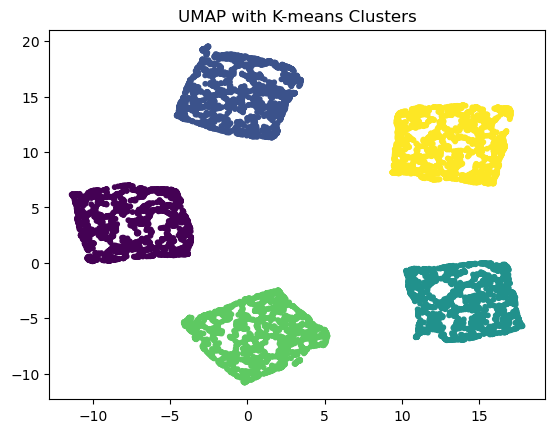

In [ ]:
# Zakładam, że X_umap to dane zredukowane przez UMAP (z Twojego wykresu)
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_umap)
silhouette_score(X_umap, clusters)

# Wizualizacja klastrów
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=clusters, s=10, cmap='viridis')
plt.title('UMAP with K-means Clusters')
plt.show()

c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


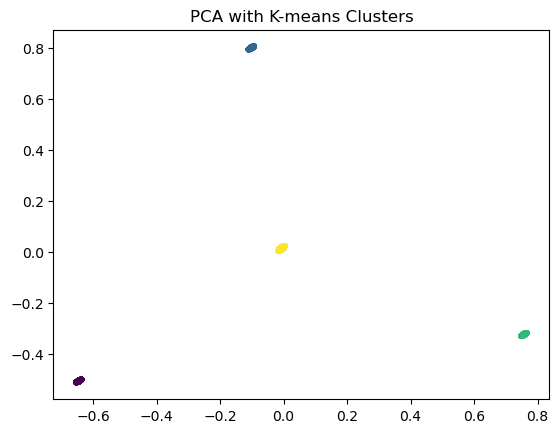

In [ ]:
# Zakładam, że X_umap to dane zredukowane przez UMAP (z Twojego wykresu)
kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(X_minmax)
silhouette_score(X_pca, clusters)

# Wizualizacja klastrów
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, s=10, cmap='viridis')
plt.title('PCA with K-means Clusters')
plt.show()

In [329]:
umap_model = umap.UMAP(n_components=5, random_state=42)
X_umap = umap_model.fit_transform(X_minmax)
kmeans_umap = KMeans(n_clusters=5, random_state=42)
clusters_umap = kmeans_umap.fit_predict(X_umap)
print("Silhouette Score (UMAP) n_comp=2:", silhouette_score(X_umap, clusters_umap))

umap_model = umap.UMAP(n_components=3, random_state=42)
X_umap = umap_model.fit_transform(X_minmax)
kmeans_umap = KMeans(n_clusters=5, random_state=42)
clusters_umap = kmeans_umap.fit_predict(X_umap)
print("Silhouette Score (UMAP) n_comp=3:", silhouette_score(X_umap, clusters_umap))

umap_model = umap.UMAP(n_components=4, random_state=42)
X_umap = umap_model.fit_transform(X_minmax)
kmeans_umap = KMeans(n_clusters=5, random_state=42)
clusters_umap = kmeans_umap.fit_predict(X_umap)
print("Silhouette Score (UMAP) n_comp=4:", silhouette_score(X_umap, clusters_umap))

umap_model = umap.UMAP(n_components=5, random_state=42)
X_umap = umap_model.fit_transform(X_minmax)
kmeans_umap = KMeans(n_clusters=5, random_state=42)
clusters_umap = kmeans_umap.fit_predict(X_umap)
print("Silhouette Score (UMAP) n_comp=5:", silhouette_score(X_umap, clusters_umap))

umap_model = umap.UMAP(n_components=6, random_state=42)
X_umap = umap_model.fit_transform(X_minmax)
kmeans_umap = KMeans(n_clusters=5, random_state=42)
clusters_umap = kmeans_umap.fit_predict(X_umap)
print("Silhouette Score (UMAP) n_comp=6:", silhouette_score(X_umap, clusters_umap))

umap_model = umap.UMAP(n_components=7, random_state=42)
X_umap = umap_model.fit_transform(X_minmax)
kmeans_umap = KMeans(n_clusters=5, random_state=42)
clusters_umap = kmeans_umap.fit_predict(X_umap)
print("Silhouette Score (UMAP) n_comp=7:", silhouette_score(X_umap, clusters_umap))

c:\Users\48530\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score (UMAP) n_comp=2: 0.6925764


c:\Users\48530\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score (UMAP) n_comp=3: 0.700084


c:\Users\48530\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score (UMAP) n_comp=4: 0.6947652


c:\Users\48530\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score (UMAP) n_comp=5: 0.6925764


c:\Users\48530\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score (UMAP) n_comp=6: 0.69267434


c:\Users\48530\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score (UMAP) n_comp=7: 0.6919152
